# PIP

In [3]:
pip install gymnasium ipywidgets

   ---------------------------------------- 2.2/2.2 MB 13.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# LOCKANDKEY

## 1 IMPORTS

In [48]:
# CELL 1: Imports & helpers
# Paste in first cell
import os
import time
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# Import your external env (must be in same folder)
from lock_key_env import LockKeyEnv

# Pygame used for menu + visualization
import pygame

# Small safe initializer used before creating fonts/displays
def pygame_safe_init():
    if not pygame.get_init():
        pygame.init()
    if not pygame.font.get_init():
        pygame.font.init()

# small helper: moving average
def moving_avg(arr, window):
    if len(arr) < window:
        return np.array(arr)
    return np.convolve(arr, np.ones(window)/window, mode='valid')


## 2 RL AGENTS

In [49]:
# ----------------- CELL 2: RL Agents (Q-Learning, Monte Carlo, Actor-Critic) -----------------
import numpy as np
from collections import defaultdict

# --- Utility to make states hashable ---
def hashable_state(s):
    """
    Convert dict, ndarray, or list observation into a hashable key.
    """
    if isinstance(s, dict):
        return tuple(sorted((k, hashable_state(v)) for k, v in s.items()))
    elif isinstance(s, np.ndarray):
        return tuple(map(float, s.flatten()))
    elif isinstance(s, (list, tuple)):
        return tuple(map(hashable_state, s))
    else:
        try:
            hash(s)
            return s
        except TypeError:
            return str(s)


# ----------------- Q-Learning Agent -----------------
class QLearningAgent:
    def __init__(self, n_states=None, n_actions=4, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))

    def select_action(self, state):
        state = hashable_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, state, action, reward, next_state, done):
        state = hashable_state(state)
        next_state = hashable_state(next_state)
        target = reward + self.gamma * np.max(self.Q[next_state]) * (1 - done)
        current = self.Q[state][action]
        self.Q[state][action] = current + self.alpha * (target - current)


# ----------------- Monte Carlo Agent -----------------
class MonteCarloAgent:
    def __init__(self, n_states=None, n_actions=4, gamma=0.9, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))
        self.returns = defaultdict(list)

    def select_action(self, state):
        state = hashable_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, episode):
        """Episode is a list of (state, action, reward)."""
        G = 0
        visited = set()
        for state, action, reward in reversed(episode):
            state = hashable_state(state)
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])
                visited.add((state, action))


# ----------------- Actor-Critic Agent -----------------
class ActorCriticAgent:
    def __init__(self, n_states=None, n_actions=4, alpha=0.1, beta=0.01, gamma=0.9):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha  # critic lr
        self.beta = beta    # actor lr
        self.gamma = gamma

        self.V = defaultdict(float)
        self.pi = defaultdict(lambda: np.ones(self.n_actions) / self.n_actions)

    def select_action(self, state):
        state = hashable_state(state)
        probs = self.pi[state]
        return np.random.choice(self.n_actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        state = hashable_state(state)
        next_state = hashable_state(next_state)

        # TD error
        td_target = reward + self.gamma * self.V[next_state] * (1 - done)
        td_error = td_target - self.V[state]
        self.V[state] += self.alpha * td_error

        # Actor update
        probs = self.pi[state]
        one_hot = np.zeros_like(probs)
        one_hot[action] = 1.0
        self.pi[state] += self.beta * td_error * (one_hot - probs)

        # Normalize
        self.pi[state] = np.clip(self.pi[state], 1e-5, 1.0)
        self.pi[state] /= np.sum(self.pi[state])


## 3 PYGAME MENU

In [50]:
# ----------------- CELL 3 (UPDATED): Dynamic algorithm parameter UI -----------------
def draw_button(screen, rect, text, font, color=(180,220,255), border=2):
    pygame.draw.rect(screen, color, rect)
    pygame.draw.rect(screen, (0,0,0), rect, border)
    txt = font.render(text, True, (0,0,0))
    screen.blit(txt, (rect.x + (rect.width - txt.get_width())//2, rect.y + (rect.height - txt.get_height())//2))

def draw_slider(screen, x, y, w, val, min_val, max_val, label, font):
    pygame.draw.rect(screen, (220,220,220), (x, y, w, 6))
    knob_x = int(x + ((val - min_val) / (max_val - min_val)) * w)
    pygame.draw.circle(screen, (80,80,200), (knob_x, y+3), 10)
    txt = font.render(f"{label}: {val:.3f}", True, (0,0,0))
    screen.blit(txt, (x, y - 28))
    return pygame.Rect(knob_x-10, y-10, 20, 20)

def draw_input_box(screen, rect, text, font, active):
    color = (200,255,200) if active else (255,255,255)
    pygame.draw.rect(screen, color, rect)
    pygame.draw.rect(screen, (0,0,0), rect, 2)
    txt_surface = font.render(text, True, (0,0,0))
    screen.blit(txt_surface, (rect.x+5, rect.y+5))

def menu_and_params(initial_params=None):
    pygame_safe_init()
    w,h = 980, 640
    screen = pygame.display.set_mode((w,h))
    pygame.display.set_caption('Locke N Key — Algorithm Setup')
    font = pygame.font.SysFont('arial', 22)
    small = pygame.font.SysFont('arial', 16)

    algo_choices = ['Q-Learning', 'Monte Carlo', 'Actor-Critic']
    algo_idx = 0

    # default parameters
    params = {
        'episodes': '500',  # stored as string for input box
        'alpha': 0.1,
        'beta': 0.01,
        'gamma': 0.9,
        'epsilon': 0.2,
    }
    if initial_params:
        params.update(initial_params)

    dragging = None
    active_box = False
    input_rect = pygame.Rect(760, 250, 150, 36)
    clock = pygame.time.Clock()
    start_sim = False
    running = True

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit(); raise SystemExit()

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RIGHT:
                    algo_idx = (algo_idx + 1) % len(algo_choices)
                elif event.key == pygame.K_LEFT:
                    algo_idx = (algo_idx - 1) % len(algo_choices)
                elif event.key == pygame.K_RETURN:
                    start_sim = True
                elif active_box:
                    if event.key == pygame.K_BACKSPACE:
                        params['episodes'] = params['episodes'][:-1]
                    elif event.unicode.isdigit():
                        params['episodes'] += event.unicode

            elif event.type == pygame.MOUSEBUTTONDOWN:
                mx,my = pygame.mouse.get_pos()
                if input_rect.collidepoint(mx,my):
                    active_box = True
                else:
                    active_box = False
                # check sliders
                if event.button == 1:
                    if 'alpha_knob' in locals() and alpha_knob.collidepoint(mx,my): dragging = 'alpha'
                    elif 'beta_knob' in locals() and beta_knob.collidepoint(mx,my): dragging = 'beta'
                    elif 'gamma_knob' in locals() and gamma_knob.collidepoint(mx,my): dragging = 'gamma'
                    elif 'eps_knob' in locals() and eps_knob.collidepoint(mx,my): dragging = 'epsilon'
            elif event.type == pygame.MOUSEBUTTONUP:
                dragging = None

            elif event.type == pygame.MOUSEMOTION and dragging:
                mx,my = pygame.mouse.get_pos()
                def update_slider(key, x, w, min_v, max_v):
                    rel = max(0, min(1, (mx - x) / w))
                    params[key] = min_v + rel * (max_v - min_v)
                if dragging == 'alpha': update_slider('alpha', 180, 300, 0.01, 1.0)
                elif dragging == 'beta': update_slider('beta', 180, 360, 0.001, 0.1)
                elif dragging == 'gamma': update_slider('gamma', 180, 420, 0.5, 0.99)
                elif dragging == 'epsilon': update_slider('epsilon', 180, 480, 0.0, 1.0)

        # --- Draw UI ---
        screen.fill((245,245,245))
        title = font.render('Locke N Key — Choose Algorithm', True, (20,20,20))
        screen.blit(title, (40,30))

        draw_button(screen, pygame.Rect(50,80,520,80),
                    f'<<  {algo_choices[algo_idx]}  >>', font, color=(180,220,255))

        algo = algo_choices[algo_idx]
        y = 200
        knobs = {}

        if algo == 'Q-Learning':
            alpha_knob = draw_slider(screen, 180, y+100, 480, params['alpha'], 0.01, 1.0, "Alpha (Learning Rate)", font)
            gamma_knob = draw_slider(screen, 180, y+160, 480, params['gamma'], 0.5, 0.99, "Gamma (Discount)", font)
            eps_knob = draw_slider(screen, 180, y+220, 480, params['epsilon'], 0.0, 1.0, "Epsilon (Exploration)", font)
        elif algo == 'Monte Carlo':
            gamma_knob = draw_slider(screen, 180, y+100, 480, params['gamma'], 0.5, 0.99, "Gamma (Discount)", font)
            eps_knob = draw_slider(screen, 180, y+160, 480, params['epsilon'], 0.0, 1.0, "Epsilon (Exploration)", font)
        elif algo == 'Actor-Critic':
            alpha_knob = draw_slider(screen, 180, y+100, 480, params['alpha'], 0.01, 1.0, "Alpha (Critic LR)", font)
            beta_knob = draw_slider(screen, 180, y+160, 480, params['beta'], 0.001, 0.1, "Beta (Actor LR)", font)
            gamma_knob = draw_slider(screen, 180, y+220, 480, params['gamma'], 0.5, 0.99, "Gamma (Discount)", font)

        # episodes input
        draw_input_box(screen, input_rect, params['episodes'], font, active_box)
        ep_label = small.render("Episodes:", True, (0,0,0))
        screen.blit(ep_label, (680, 260))

        hint = small.render('← → change algorithm | ENTER start | Type episodes', True, (60,60,60))
        screen.blit(hint, (50, 580))

        pygame.display.update()
        clock.tick(30)

        if start_sim:
            pygame.quit()
            params['episodes'] = int(params['episodes']) if params['episodes'].isdigit() else 500
            return algo_choices[algo_idx], params


## 4 TRAINING LOOP

In [51]:
# ----------------- CELL 4: Training loop + visualization with HUD (fixed + improved) -----------------
def train_and_visualize(algo_name, params, save_path="lockkey_policy.pkl"):
    pygame_safe_init()

    # --- Environment setup ---
    env = LockKeyEnv(render_mode='human', size=6, phase=int(params.get('phase', 5)))
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    episodes = int(params.get('episodes', 800))
    gamma = float(params.get('gamma', 0.9))

    # --- Agent creation ---
    if algo_name == 'Q-Learning':
        agent = QLearningAgent(n_states, n_actions,
                               alpha=float(params.get('alpha', 0.1)),
                               gamma=gamma,
                               epsilon=float(params.get('epsilon', 0.2)))
    elif algo_name == 'Monte Carlo':
        agent = MonteCarloAgent(n_states, n_actions,
                                gamma=gamma,
                                epsilon=float(params.get('epsilon', 0.1)))
    else:  # Actor-Critic
        agent = ActorCriticAgent(n_states, n_actions,
                                 alpha=float(params.get('alpha', 0.1)),   # critic lr
                                 beta=float(params.get('beta', 0.01)),    # actor lr
                                 gamma=gamma)

    episode_rewards, successes = [], []

    pygame_safe_init()
    font = pygame.font.SysFont('arial', 18)
    start_time = time.time()

    try:
        if hasattr(env, 'start_pygame'):
            try:
                env.start_pygame()
            except Exception:
                pass

        # --- Main training loop ---
        for ep in range(1, episodes + 1):
            obs = env.reset()
            env.current_episode = ep
            done = False
            total_r = 0
            steps = 0
            episode_hist = []

            while not done and steps < 400:
                # Allow quitting mid-run
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        env.close(); pygame.quit(); raise SystemExit()
                    elif event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                        env.close(); pygame.quit(); raise SystemExit()

                # Agent selects action
                s = obs
                a = agent.select_action(s) if hasattr(agent, 'select_action') else agent.policy(s)
                obs2, r, done, trunc, info = env.step(a)
                total_r += r
                steps += 1

                if isinstance(agent, MonteCarloAgent):
                    episode_hist.append((s, a, r))
                else:
                    agent.update(s, a, r, obs2, done)

                obs = obs2

                # --- HUD (right panel) ---
                try:
                    screen = env.window
                    if screen:
                        grid_px = env.size * env.cell_size
                        panel_width = 240
                        total_width = grid_px + panel_width

                        if screen.get_width() < total_width:
                            env.window = pygame.display.set_mode((total_width, grid_px))

                        # Draw background for panel
                        panel_rect = pygame.Rect(grid_px, 0, panel_width, grid_px)
                        pygame.draw.rect(screen, (25, 25, 40), panel_rect)
                        pygame.draw.rect(screen, (80, 80, 120), panel_rect, 2)

                        # Panel content
                        lines = [
                            f"Algorithm: {algo_name}",
                            f"Episode: {ep}/{episodes}",
                            f"Steps: {steps}",
                            f"Reward: {total_r:.2f}",
                            f"Epsilon: {getattr(agent, 'epsilon', 0):.2f}",
                            f"Elapsed: {time.time() - start_time:.1f}s"
                        ]

                        y = 30
                        for line in lines:
                            text_surface = font.render(line, True, (255, 255, 255))
                            screen.blit(text_surface, (grid_px + 20, y))
                            y += 28

                        # Reward progress bar
                        max_bar = 20
                        bar_len = int(np.clip(total_r / max_bar, 0, 1) * (panel_width - 40))
                        pygame.draw.rect(screen, (0, 200, 0), (grid_px + 20, y + 10, bar_len, 18))
                except Exception:
                    pass

                # Render env
                try:
                    env.render(font=font, episode=ep, ep_reward=total_r)
                except TypeError:
                    env.render()

                # Console updates
                if steps % 30 == 0:
                    print(f"Ep {ep} | Step {steps:03d} | Reward={total_r:.2f} | Eps={getattr(agent, 'epsilon', 0):.2f}", end='\r')

            # End of episode
            if isinstance(agent, MonteCarloAgent):
                agent.update(episode_hist)

            if hasattr(agent, 'epsilon'):
                agent.epsilon = max(0.01, agent.epsilon * 0.995)

            episode_rewards.append(total_r)
            successes.append(1 if done and total_r > 0 else 0)
            print(f"\n✅ Episode {ep}/{episodes} finished | Reward={total_r:.2f} | Steps={steps}")

    finally:
        try:
            env.close()
        except Exception:
            pass

    # --- Save policy ---
    try:
        def safe_convert(obj):
            if isinstance(obj, defaultdict):
                obj = {k: safe_convert(v) for k, v in obj.items()}
            return obj

        data_to_save = None
        if algo_name in ['Q-Learning', 'Monte Carlo']:
            data_to_save = safe_convert(agent.Q)
        else:
            data_to_save = {'V': safe_convert(agent.V), 'pi': safe_convert(agent.pi)}

        with open(save_path, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"✅ Saved {algo_name} policy successfully to {save_path}")

    except Exception as e:
        print(f"⚠️ Warning: Could not save policy due to {e}")

    # --- Plot results ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    window = min(50, max(1, len(successes)))
    if len(successes) >= window:
        mov = moving_avg(successes, window)
        x = np.arange(window - 1, window - 1 + len(mov))
        plt.plot(x, mov)
    else:
        plt.plot(successes)
    plt.title(f'Success Rate (moving avg window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()

    return episode_rewards, successes


## 5 RUN WHOLE FLOW

In [52]:
algo, params = menu_and_params()
print("Chosen algorithm:", algo)
print("Parameters:", params)

visuals = {...}

rewards, successes = train_and_visualize(algo, params, save_path='lockkey_policy.pkl')
print("Training complete. Saved policy and plotted results.")


Chosen algorithm: Q-Learning
Parameters: {'episodes': 500, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9, 'epsilon': 0.2}


SystemExit: 

## 6 RESULTS GRAPHS

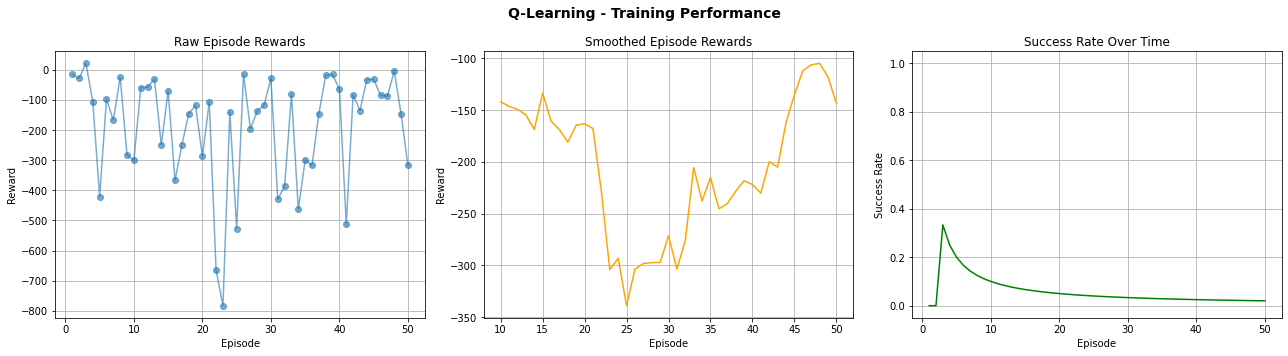

In [ ]:
# ----------------- CELL 6: Results & Comparison -----------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# === 1) Plot Learning Curves (raw + smoothed rewards + success rate) ===
def plot_learning_curves(rewards, successes, algo_name, smooth_window=10):
    episodes = np.arange(1, len(rewards) + 1)
    
    plt.figure(figsize=(18, 5))
    plt.suptitle(f"{algo_name} - Training Performance", fontsize=14, fontweight='bold')

    # 1️⃣ Raw Reward Curve
    plt.subplot(1, 3, 1)
    plt.plot(episodes, rewards, marker='o', alpha=0.6, label='Raw Reward')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Raw Episode Rewards")
    plt.grid(True)

    # 2️⃣ Smoothed Reward Curve
    plt.subplot(1, 3, 2)
    if len(rewards) >= smooth_window:
        smooth_rewards = np.convolve(rewards, np.ones(smooth_window)/smooth_window, mode='valid')
        x = np.arange(smooth_window, len(rewards)+1)
        plt.plot(x, smooth_rewards, color='orange', label=f'Smoothed (window={smooth_window})')
    else:
        plt.plot(episodes, rewards, color='orange', label='Smoothed (fallback)')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Smoothed Episode Rewards")
    plt.grid(True)

    # 3️⃣ Success Rate Curve
    plt.subplot(1, 3, 3)
    success_rate = np.cumsum(successes) / episodes
    plt.plot(episodes, success_rate, color='green', label='Success Rate')
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.title("Success Rate Over Time")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# === 2) Summary Table (optional multi-algo comparison) ===
def summarize_results(all_results):
    """
    all_results = {
        'Q-Learning': {'rewards': [...], 'successes': [...]},
        'Monte Carlo': {...},
        'Actor-Critic': {...}
    }
    """
    data = []
    for algo, res in all_results.items():
        rewards = np.array(res['rewards'])
        successes = np.array(res['successes'])
        avg_reward = np.mean(rewards)
        max_reward = np.max(rewards)
        success_rate = np.mean(successes)
        data.append([algo, avg_reward, max_reward, success_rate])
    
    df = pd.DataFrame(data, columns=['Algorithm', 'Avg Reward', 'Max Reward', 'Success Rate'])
    display(HTML("<h3>📊 Algorithm Performance Summary</h3>"))
    display(df.round(3))

# === 3) Example usage ===
# If you trained only one algorithm:
plot_learning_curves(rewards, successes, algo_name=algo)

# If you trained multiple algorithms separately:
# all_results = {
#     'Q-Learning': {'rewards': q_rewards, 'successes': q_successes},
#     'Monte Carlo': {'rewards': mc_rewards, 'successes': mc_successes},
#     'Actor-Critic': {'rewards': ac_rewards, 'successes': ac_successes}
# }
# summarize_results(all_results)
